In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

from mlxtend.evaluate import bias_variance_decomp

from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

In [2]:
filepath = 'heart.csv'
dataset=pd.read_csv(filepath,encoding = 'unicode_escape')
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,M,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,M,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,F,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,M,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,F,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
# check for duplicates and null values
print('sum of duplicated values{}\n'.format(dataset.duplicated().sum()))
print('sum of null values: {}'.format(dataset.isnull().sum()))


sum of duplicated values1

sum of null values: age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [4]:
x = dataset.iloc[:,:-1].values 
y = dataset['target'].values.reshape(-1,1) 
print("y shape :",y.shape) 

y shape : (303, 1)


In [5]:
from sklearn.preprocessing import MinMaxScaler 


In [6]:

scaler = MinMaxScaler() 
x = scaler.fit_transform(x.astype('float')) 
y = scaler.fit_transform(y)

ValueError: could not convert string to float: 'M'

In [7]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=1) 

In [8]:
lr = LinearRegression(n_jobs=-1) 
lr.fit(x_train,y_train) 
y_pred = scaler.inverse_transform(lr.predict(x_test)) 
print("Predictions: \n",y_pred[:5]) 

ValueError: could not convert string to float: 'M'

In [115]:
train_mse = {'lin_reg':mse(scaler.inverse_transform(y_train), 
                           scaler.inverse_transform(lr.predict(x_train)))} 
test_mse = {'lin_reg':mse(scaler.inverse_transform(y_test),y_pred)} 
print("Training MSE : {:.7f}".format(train_mse['lin_reg'])) 
print("Generalisation Error: {:.7f}".format(test_mse['lin_reg'])) 

Training MSE : 0.1142450
Generalisation Error: 0.1437186


The Training datasize with lowest bias and variance is : 198


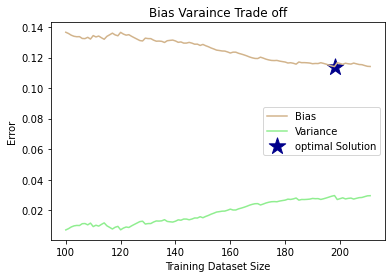

In [116]:
bias = [] 
variance = [] 
for i in range(100,len(x_train)): 
    x_data = x_train[:i,:];y_data = y_train[:i,:] 
    model = LinearRegression(n_jobs=-1) 
    model.fit(x_data,y_data) 
    bias.append(mse(scaler.inverse_transform(y_data), 
                           scaler.inverse_transform(lr.predict(x_data)))) 
    variance.append(abs(bias[-1]-mse(scaler.inverse_transform(y_test), 
                           scaler.inverse_transform(lr.predict(x_test))))) 
bias = pd.Series(data=bias,index=range(100,len(x_train))) 
variance = pd.Series(data=variance,index=range(100,len(x_train))) 
diff = pd.Series(data=abs((bias-variance)),index=range(100,len(x_train))) 
print("The Training datasize with lowest bias and variance is : {}".format(diff.idxmin())) 
plt.plot(range(100,len(x_train)),bias,label='Bias',color='tan') 
plt.plot(range(100,len(x_train)),variance,label='Variance',color='lightgreen') 
plt.scatter(diff.idxmin(),bias[diff.idxmin()],marker='*',color='darkblue',s=300,label='optimal Solution') 
plt.legend() 
plt.title('Bias Varaince Trade off') 
plt.ylabel('Error') 
plt.xlabel('Training Dataset Size') 
plt.show()

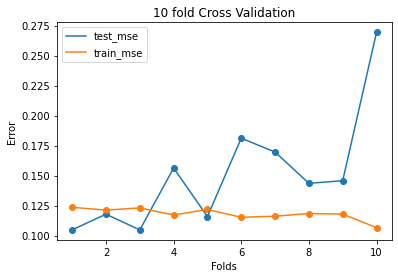

In [117]:
from sklearn.model_selection import cross_validate 
cv_results = cross_validate(lr,x,y,cv=10,n_jobs=1,scoring='neg_mean_squared_error',return_train_score=True) 
plt.plot(range(1,len(cv_results['test_score'])+1),abs(cv_results['test_score']),label='test_mse') 
plt.scatter(range(1,len(cv_results['test_score'])+1),abs(cv_results['test_score'])) 
plt.plot(range(1,len(cv_results['train_score'])+1),abs(cv_results['train_score']),label='train_mse') 
plt.scatter(range(1,len(cv_results['train_score'])+1),abs(cv_results['train_score'])) 
plt.title('10 fold Cross Validation') 
plt.xlabel('Folds') 
plt.ylabel('Error') 
plt.legend() 
plt.show()

In [118]:
from sklearn.linear_model import ElasticNet 

Train mse :  0.24819775720897122
Test mse :  0.2476036112339068


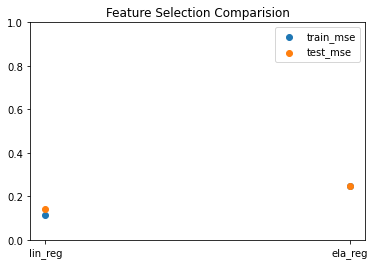

Train_mse :  {'lin_reg': 0.1142449910912486, 'ela_reg': 0.24819775720897122}
Test_mse :  {'lin_reg': 0.1437185958164972, 'ela_reg': 0.2476036112339068}


In [119]:
ela = ElasticNet() 
ela.fit(x_train,y_train) 
train_mse['ela'] = mse(scaler.inverse_transform(y_train), 
                           scaler.inverse_transform(ela.predict(x_train).reshape(-1,1))) 
test_mse['ela'] = mse(scaler.inverse_transform(y_test), 
                           scaler.inverse_transform(ela.predict(x_test).reshape(-1,1))) 
print("Train mse : ",train_mse['ela']) 
print("Test mse : ",test_mse['ela']) 
plt.scatter(train_mse.keys(),train_mse.values(),label='train_mse') 
plt.scatter(test_mse.keys(),test_mse.values(),label='test_mse') 
plt.ylim(0,1) 
plt.legend() 
plt.title('Feature Selection Comparision') 
plt.show() 
print("Train_mse : ",train_mse) 
print("Test_mse : ",test_mse) 